# import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
warnings.filterwarnings("ignore")


# Load Data

In [2]:
data = pd.read_csv("loan_approval_dataset.csv")
print(f"Dataset Shape: {data.shape}")
data.head()

Dataset Shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


# EDA

In [8]:
print("=== Data Info ===")
data.info()
data.columns = data.columns.str.strip()
print("\n=== Missing Values ===")
print(data.isnull().sum())

print("\n=== Class Distribution ===")
print(data['loan_status'].value_counts())
print(data['loan_status'].value_counts(normalize=True))

=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ 

In [3]:
data.describe()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2135.000000,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1232.498479,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1068.000000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2135.000000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,3202.000000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


In [4]:
data.describe(include="O")

,education,self_employed,loan_status
count,4269,4269,4269
unique,2,2,2
top,Graduate,Yes,Approved
freq,2144,2150,2656


In [5]:
data.duplicated().sum()

0

#  Visualization

In [9]:
data["loan_status"].unique()

array([' Approved', ' Rejected'], dtype=object)

In [10]:
# Strip whitespace
data['education'] = data['education'].str.strip()
data['self_employed'] = data['self_employed'].str.strip()
data['loan_status'] = data['loan_status'].str.strip()

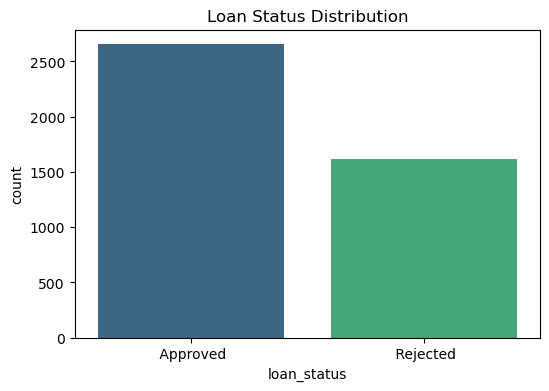

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='loan_status', data=data, palette='viridis')
plt.title('Loan Status Distribution')
plt.show()

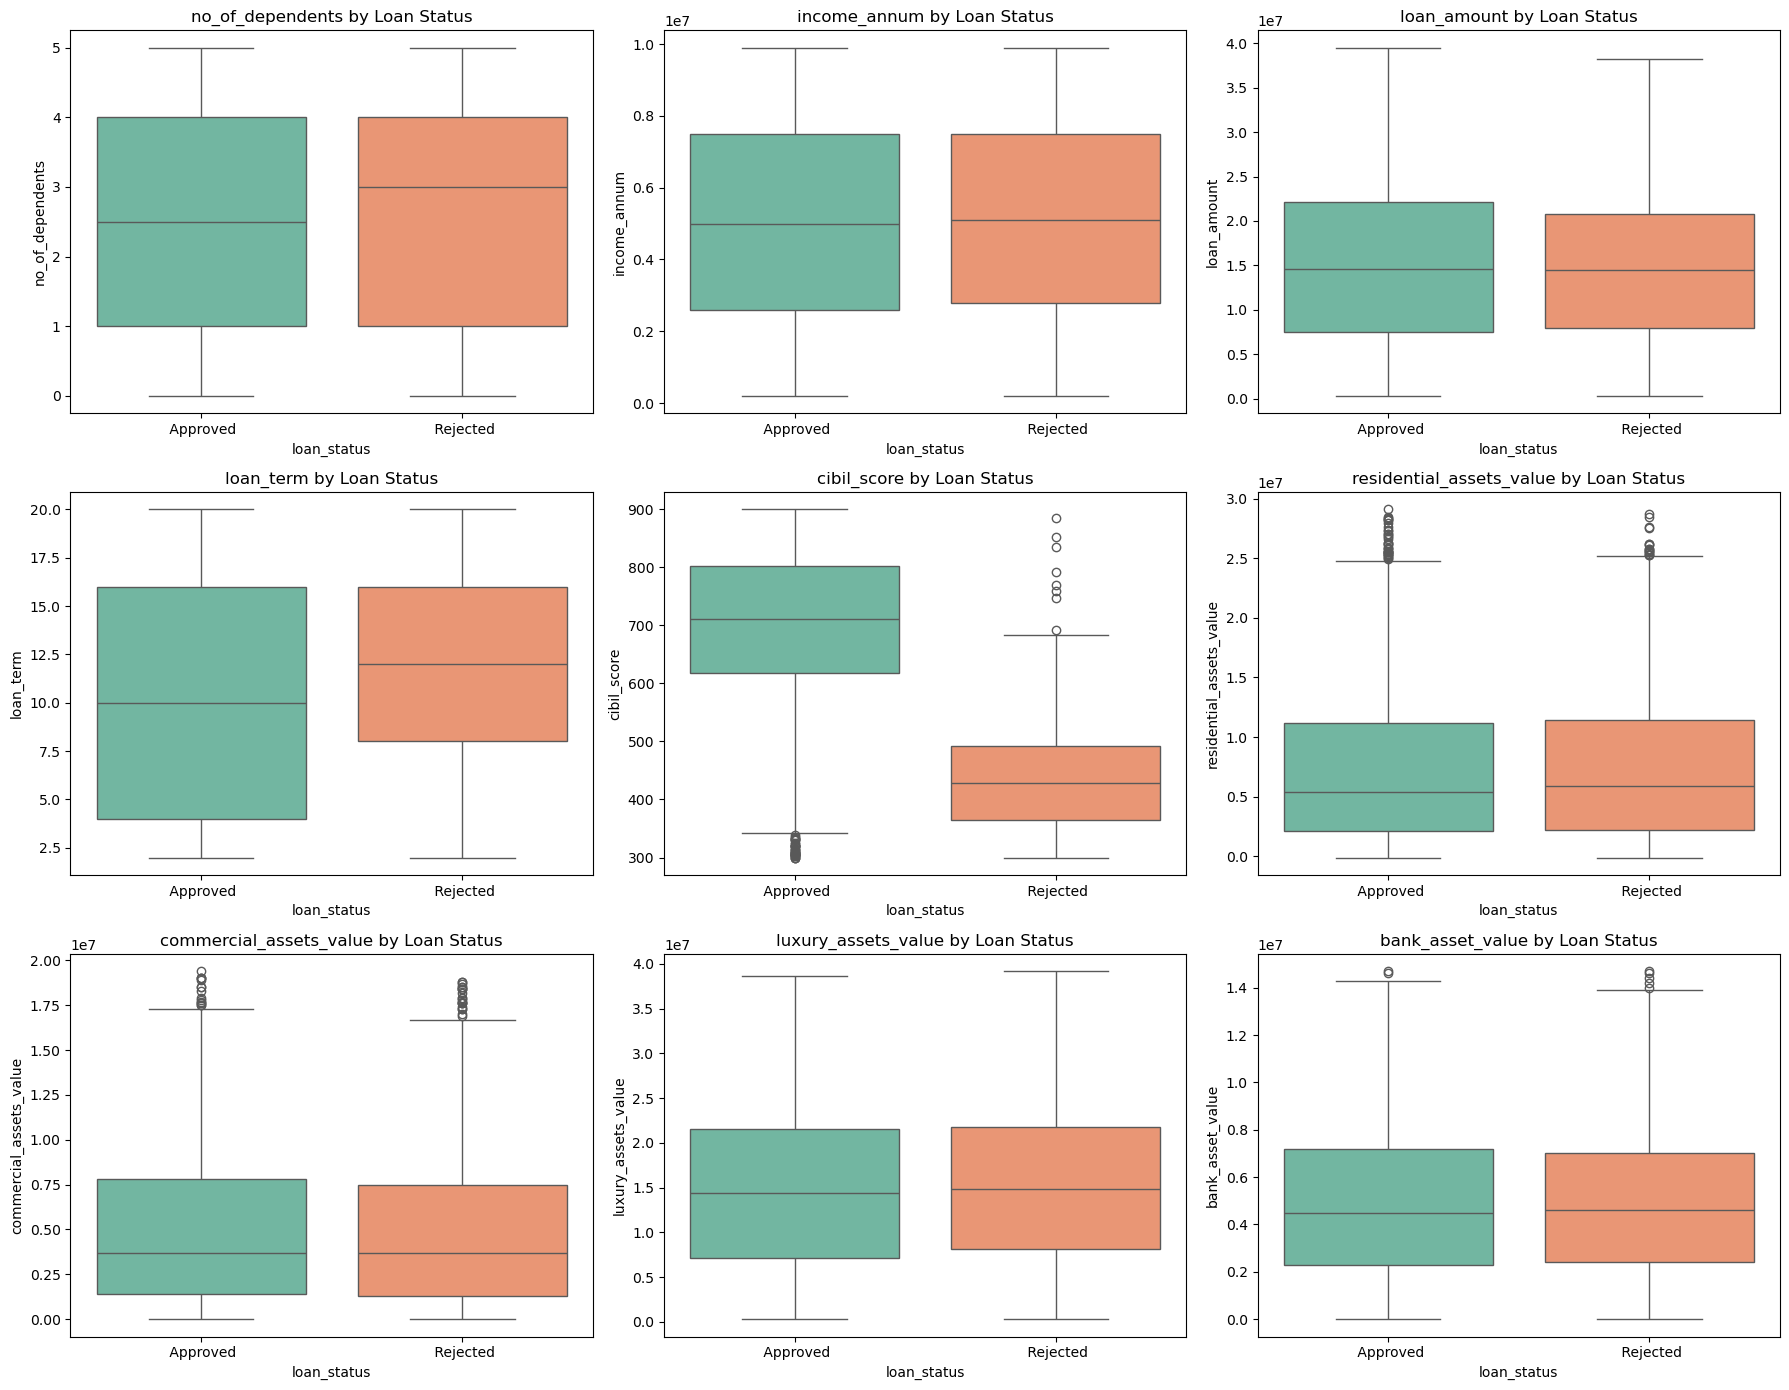

In [5]:
# Numerical Features Distribution by Loan Status
num_cols = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
            'cibil_score', 'residential_assets_value', 'commercial_assets_value',
            'luxury_assets_value', 'bank_asset_value']

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.ravel()
for i, col in enumerate(num_cols):
    sns.boxplot(x='loan_status', y=col, data=data, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{col} by Loan Status')
plt.tight_layout()
plt.show()

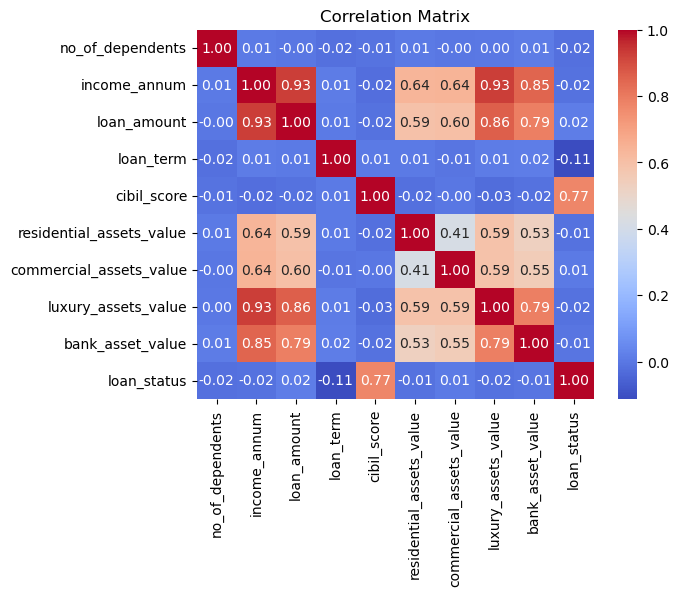

In [8]:
corr = pd.concat([data[num_cols], 
                  data['loan_status'].map({'Approved': 1, 'Rejected': 0})], 
                 axis=1).corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [11]:
cat_cols = ['education', 'self_employed']
for col in cat_cols:
    print(f"\n{col}:")
    print(data[col].value_counts())


education:
education
Graduate        2144
Not Graduate    2125
Name: count, dtype: int64

self_employed:
self_employed
Yes    2150
No     2119
Name: count, dtype: int64


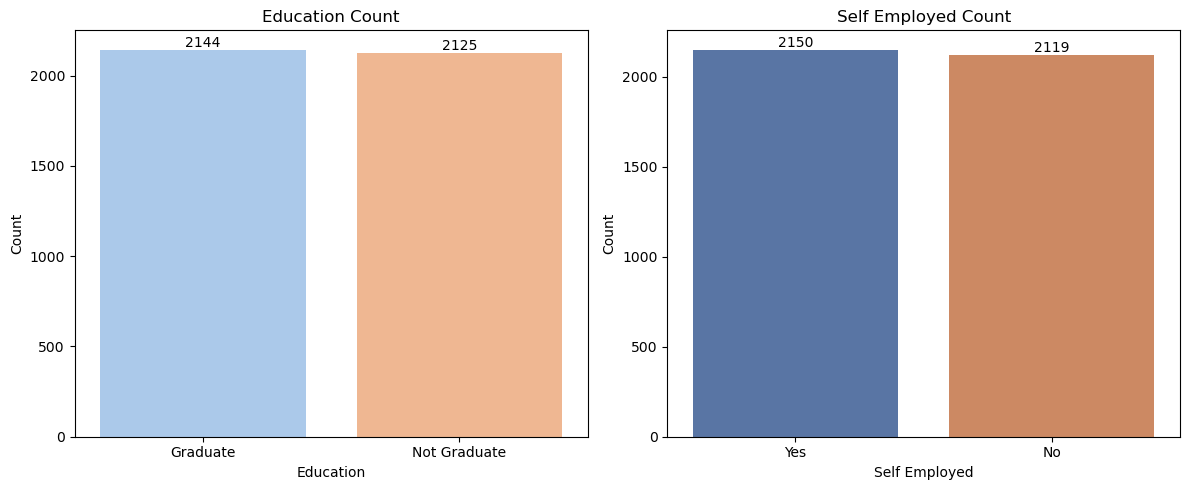

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Education plot
sns.barplot(
    x=data['education'].value_counts().index,
    y=data['education'].value_counts().values,
    ax=axes[0],
    palette='pastel'
)
axes[0].set_title('Education Count')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Education')
for container in axes[0].containers:
    axes[0].bar_label(container)
# Self Employed plot
sns.barplot(
    x=data['self_employed'].value_counts().index,
    y=data['self_employed'].value_counts().values,
    ax=axes[1],
    palette='deep'
)
axes[1].set_title('Self Employed Count')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Self Employed')
for container in axes[1].containers:
    axes[1].bar_label(container)

plt.tight_layout()
plt.show()


# Feature Engineering & Preprocessing

## Train Test split 

In [10]:
X = data.drop(columns=['loan_id', 'loan_status'])
y = data['loan_status'].map({'Approved':1, 'Rejected':0})
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessor
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['education', 'self_employed']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

# Modeling

In [11]:
# --- MODEL PIPELINE WITH SMOTE + CLASSIFICATION ---
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=['Rejected', 'Approved']))
    
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Rejected', 'Approved'], 
                yticklabels=['Rejected', 'Approved'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()
    
    return auc

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Logistic Params: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.23357214690901212}

=== Logistic Regression (SMOTE + Tuned) ===
              precision    recall  f1-score   support

    Rejected       0.88      0.92      0.90       323
    Approved       0.95      0.93      0.94       531

    accuracy                           0.93       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.93      0.93      0.93       854

ROC-AUC: 0.9735


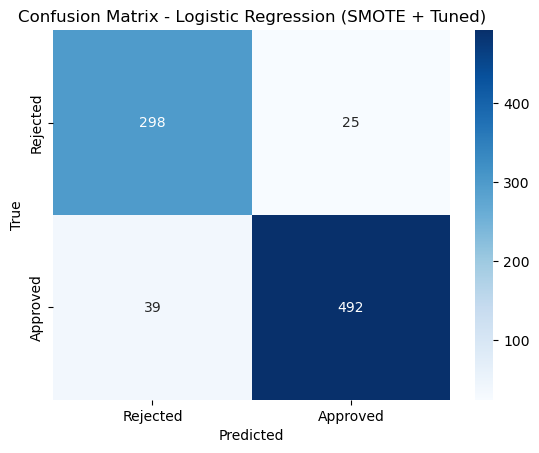

In [12]:
# --- LOGISTIC REGRESSION + Random Search + SMOTE ---

log_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

log_param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

log_search = RandomizedSearchCV(
    log_pipe, log_param_grid, n_iter=20, cv=5, scoring='f1', 
    random_state=42, n_jobs=-1, verbose=1
)

log_search.fit(X_train, y_train)
best_log = log_search.best_estimator_

print("Best Logistic Params:", log_search.best_params_)
log_auc = evaluate_model(best_log, X_test, y_test, "Logistic Regression (SMOTE + Tuned)")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Tree Params: {'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None, 'classifier__criterion': 'entropy'}

=== Decision Tree (SMOTE + Tuned) ===
              precision    recall  f1-score   support

    Rejected       0.96      0.98      0.97       323
    Approved       0.98      0.98      0.98       531

    accuracy                           0.98       854
   macro avg       0.97      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

ROC-AUC: 0.9790


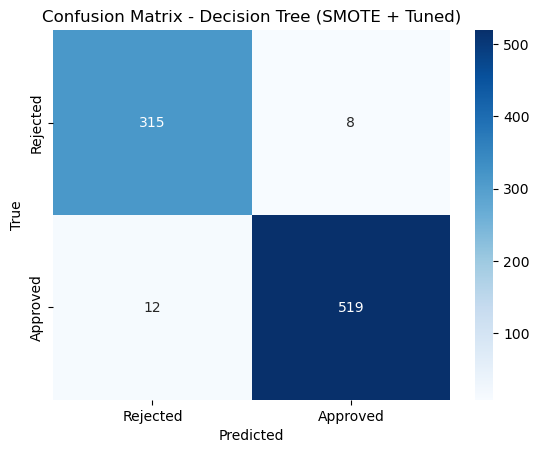

In [13]:
# --- DECISION TREE + Random Search + SMOTE ---

dt_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

dt_search = RandomizedSearchCV(
    dt_pipe, dt_param_grid, n_iter=30, cv=5, scoring='f1', 
    random_state=42, n_jobs=-1, verbose=1
)

dt_search.fit(X_train, y_train)
best_dt = dt_search.best_estimator_

print("Best Tree Params:", dt_search.best_params_)
dt_auc = evaluate_model(best_dt, X_test, y_test, "Decision Tree (SMOTE + Tuned)")

# Compare Models

In [14]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'ROC-AUC': [log_auc, dt_auc],
    'Best Params': [log_search.best_params_, dt_search.best_params_]
})

print("\n=== Model Comparison ===")
print(results)


=== Model Comparison ===
                 Model   ROC-AUC  \
0  Logistic Regression  0.973454   
1        Decision Tree  0.979002   

                                         Best Params  
0  {'classifier__solver': 'saga', 'classifier__pe...  
1  {'classifier__min_samples_split': 5, 'classifi...  


# Feature Importance (Decision Tree)

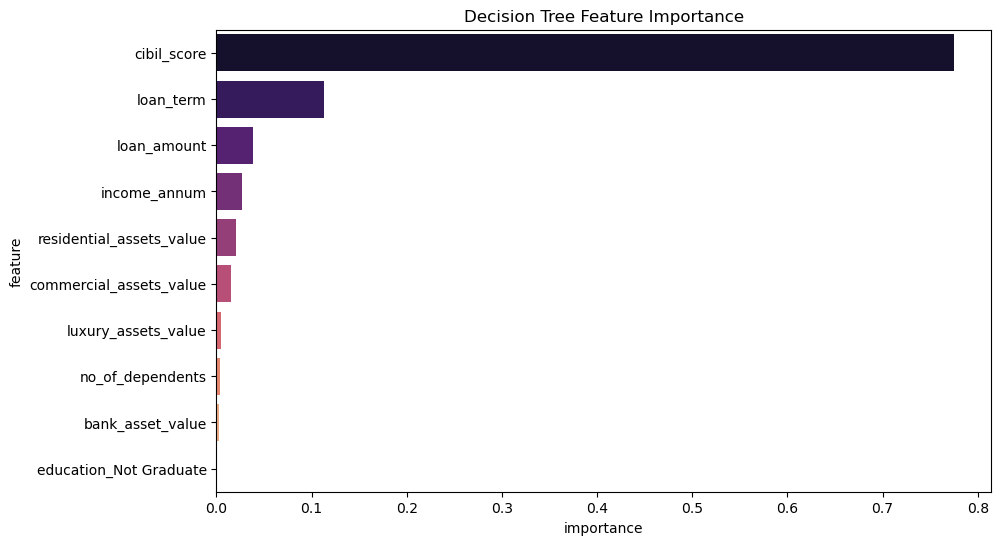

In [15]:
# Extract feature names after one-hot
ohe = best_dt.named_steps['preprocessor'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_features)

# Coefficients / Importance
if hasattr(best_dt.named_steps['classifier'], 'coef_'):
    importances = np.abs(best_dt.named_steps['classifier'].coef_[0])
    title = "Logistic Regression |Coefficients|"
else:
    importances = best_dt.named_steps['classifier'].feature_importances_
    title = "Decision Tree Feature Importance"

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=importance_df.head(10), palette='magma')
plt.title(title)
plt.show()

# Pick the Best Models

In [16]:
if log_auc >= dt_auc:
    best_model = best_log
    model_name = "Logistic"
else:
    best_model = best_dt
    model_name = "DecisionTree"

print(f"\n>>> BEST MODEL: {model_name} (AUC = {max(log_auc,dt_auc):.4f})")


>>> BEST MODEL: DecisionTree (AUC = 0.9790)


# Save the mmodels

In [20]:
joblib.dump(best_model, "loan_approval_best.pkl")
print("Model saved as 'loan_approval_best.pkl'")

Model saved as 'loan_approval_best.pkl'
